In [1]:
import cartopy

In [2]:
import numba

In [3]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import geopandas
import matplotlib as mpl

In [4]:
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from netCDF4 import Dataset
import xarray
from numba import jit

@jit(nopython=True, parallel=False)
def corr(x,y):
    res = np.corrcoef(x,y)[0,1]
    return res

@jit(nopython=True, parallel=False)
def mapcorr(x,y,res):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            res[i,j] = corr(x[:,i,j],y[:,i,j])
    return res

@jit(nopython=True, parallel=False)
def mapcorr2(x,y,res):
    res[:,:] = np.nan
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            ind = x[:,i,j] > -100.0
            res[i,j] = corr(x[ind,i,j],y[ind,i,j])
#             if i == 35 and j == 35:
#                 print(x[ind,i,j])
    return res

@jit(nopython=True, parallel=False)
def gridcorr(x,y,res):
    for i in range(y.shape[1]):
        for j in range(y.shape[2]):
            ind = y[:,i,j] > 0
            res[i,j] = corr(x[ind,i,j], y[ind,i,j])
    return res

@jit(nopython=True, parallel=False)
def premask(y,res):
    res[:,:,:] = np.nan
    for i in range(y.shape[1]):
        for j in range(y.shape[2]):
            for k in range(1,364):
                if y[k,i,j] > 0.0:
                    res[k-5:k,i,j] = 1.0
                    
                else:
                     res[k,i,j] = np.nan
    return res

@jit(nopython=True, parallel=False)
def postmask(y,res):
    res[:,:,:] = np.nan
    for i in range(y.shape[1]):
        for j in range(y.shape[2]):
            for k in range(363,0,-1):
                if y[k,i,j] > 0.0:
                    res[k:k+5,i,j] = 1.0
                else:
                    res[k,i,j] = np.nan
    return res


In [6]:
tas = xarray.open_mfdataset(r'\Users\andersg\Documents\ERA5\Extreme Indices Files.nc\George-V2-2010-tas*.nc')
tsl = xarray.open_mfdataset(r'\Users\andersg\Documents\ERA5\Extreme Indices Files.nc\George-V2-2010-tsl*.nc')

In [7]:
tas = tas.where(tas['latitude'] >= 47.45 , drop=True)
tas = tas.where(tas['latitude'] <= 54.95 , drop=True)
tas = tas.where(tas['longitude'] >= 5.95 , drop=True)
tas = tas.where(tas['longitude'] <= 14.95 , drop=True)

tsl = tsl.where(tsl['latitude'] >= 47.45 , drop=True)
tsl = tsl.where(tsl['latitude'] <= 54.95 , drop=True)
tsl = tsl.where(tsl['longitude'] >= 5.95 , drop=True)
tsl = tsl.where(tsl['longitude'] <= 14.95 , drop=True)

In [8]:
SNR = Dataset(r"\Users\andersg\Documents\ERA5\Surface Radiation Files.nc\era5-2010_SNR_George.nc")
H = Dataset(r"\Users\andersg\Documents\ERA5\Surface Radiation Files.nc\era5-2010_H_George.nc")
LHF = Dataset(r"\Users\andersg\Documents\ERA5\Surface Radiation Files.nc\era5-2010_LHF_George.nc")
GHF = Dataset(r"\Users\andersg\Documents\ERA5\Surface Radiation Files.nc\era5-2010_GHF_George.nc")

SNR_latitude = SNR.variables['latitude'][:]  
SNR_longitude = SNR.variables['longitude'][:]
SNR_time = SNR.variables['time'][:]
SNR_ssr = (SNR.variables['ssr'][:])/(3600)
SNR_ssr.units = "W m**-2"

H_latitude = H.variables['latitude'][:]  
H_longitude = H.variables['longitude'][:]
H_time = H.variables['time'][:]
H_sshf = H.variables['sshf'][:]/(3600)
H_sshf.units = "W m**-2"

LHF_latitude = LHF.variables['latitude'][:]  
LHF_longitude = LHF.variables['longitude'][:]
LHF_time = LHF.variables['time'][:]
LHF_slhf = LHF.variables['slhf'][:]/(3600)
LHF_slhf.units = "W m**-2"

GHF_latitude = GHF.variables['latitude'][:]  
GHF_longitude = GHF.variables['longitude'][:]
GHF_time = GHF.variables['time'][:]
GHF_GHF = GHF.variables['GHF'][:]
GHF_GHF.units = "W m**-2"

In [9]:
fils = -32767.0

LHF_slhf = np.array(LHF_slhf[:,:,:])
ind = LHF_slhf[:,:,:] == fils
LHF_slhf[ind] = np.nan

H_sshf = np.array(H_sshf[:,:,:])
ind = H_sshf[:,:,:] == fils
H_sshf[ind] = np.nan

SNR_ssr = np.array(SNR_ssr[:,:,:])
ind = SNR_ssr[:,:,:] == fils
SNR_ssr[ind] = np.nan

new_LHF_slhf = np.ndarray(shape=(LHF_slhf.shape[0], LHF_slhf.shape[1], LHF_slhf.shape[2]))
new_H_sshf = np.ndarray(shape=(H_sshf.shape[0], H_sshf.shape[1], H_sshf.shape[2]))
new_SNR_ssr = np.ndarray(shape=(SNR_ssr.shape[0], SNR_ssr.shape[1], SNR_ssr.shape[2]))
new_GHF_GHF = np.ndarray(shape=(GHF_GHF.shape[0], GHF_GHF.shape[1], GHF_GHF.shape[2]))

for i in range(1, 8760):
    if i%24 != 1:
        new_LHF_slhf[i,:,:] = LHF_slhf[i,:,:] - LHF_slhf[i-1,:,:]
        new_H_sshf[i,:,:] = H_sshf[i,:,:] - H_sshf[i-1,:,:]
        new_SNR_ssr[i,:,:] = SNR_ssr[i,:,:] - SNR_ssr[i-1,:,:]
        #new_GHF_GHF[i,:,:] = GHF_GHF[i,:,:] - GHF_GHF[i-1,:,:] Caluclated GHF from other fluxes
        
    elif i%24 == 1:
        new_LHF_slhf[i,:,:] = LHF_slhf[i,:,:]
        new_H_sshf[i,:,:] = H_sshf[i,:,:]
        new_SNR_ssr[i,:,:] = SNR_ssr[i,:,:]
        #new_GHF_GHF[i,:,:] = GHF_GHF[i,:,:]

In [10]:
new_GHF_GHF = new_LHF_slhf+new_H_sshf+new_SNR_ssr
new_LHF_slhf = new_LHF_slhf[1:new_LHF_slhf.shape[0],:,:]
new_H_sshf = new_H_sshf[1:new_H_sshf.shape[0],:,:]
new_SNR_ssr = new_SNR_ssr[1:new_SNR_ssr.shape[0],:,:]
new_GHF_GHF = new_GHF_GHF[1:new_GHF_GHF.shape[0],:,:]

In [11]:
GHF_daily_avg = np.ndarray(shape=(365, LHF_slhf.shape[1], LHF_slhf.shape[2]))
LHF_daily_avg = np.ndarray(shape=(365, LHF_slhf.shape[1], LHF_slhf.shape[2]))
H_daily_avg = np.ndarray(shape=(365, LHF_slhf.shape[1], LHF_slhf.shape[2]))
SNR_daily_avg = np.ndarray(shape=(365, LHF_slhf.shape[1], LHF_slhf.shape[2]))

for k in range(1,8760):
    if k%24 == 0:
        GHF_daily_avg[k//24,:,:] = np.nanmean(new_GHF_GHF[k-23:k,:,:], axis = 0)
        LHF_daily_avg[k//24,:,:] = np.nanmean(new_LHF_slhf[k-23:k,:,:], axis = 0)
        H_daily_avg[k//24,:,:] = np.nanmean(new_H_sshf[k-23:k,:,:], axis = 0)
        SNR_daily_avg[k//24,:,:] = np.nanmean(new_SNR_ssr[k-23:k,:,:], axis = 0)
        

C:\Users\andersg\AppData\Local\Temp\ipykernel_10508\4255918643.py:8: RuntimeWarning: Mean of empty slice
  GHF_daily_avg[k//24,:,:] = np.nanmean(new_GHF_GHF[k-23:k,:,:], axis = 0)
C:\Users\andersg\AppData\Local\Temp\ipykernel_10508\4255918643.py:9: RuntimeWarning: Mean of empty slice
  LHF_daily_avg[k//24,:,:] = np.nanmean(new_LHF_slhf[k-23:k,:,:], axis = 0)
C:\Users\andersg\AppData\Local\Temp\ipykernel_10508\4255918643.py:10: RuntimeWarning: Mean of empty slice
  H_daily_avg[k//24,:,:] = np.nanmean(new_H_sshf[k-23:k,:,:], axis = 0)
C:\Users\andersg\AppData\Local\Temp\ipykernel_10508\4255918643.py:11: RuntimeWarning: Mean of empty slice
  SNR_daily_avg[k//24,:,:] = np.nanmean(new_SNR_ssr[k-23:k,:,:], axis = 0)


In [12]:
GHF_daily_avg = GHF_daily_avg[1:GHF_daily_avg.shape[0],:,:]
LHF_daily_avg = LHF_daily_avg[1:LHF_daily_avg.shape[0],:,:]
H_daily_avg = H_daily_avg[1:H_daily_avg.shape[0],:,:]
SNR_daily_avg = SNR_daily_avg[1:SNR_daily_avg.shape[0],:,:]

In [13]:
GHF_tas = np.ndarray(shape=(75,90))
mapcorr(GHF_daily_avg,tas['t2m'].values[1:,:,:],GHF_tas)
GHF_tsl = np.ndarray(shape=(75,90))
mapcorr(GHF_daily_avg,tsl['stl1'].values[1:,:,:],GHF_tsl)

LHF_tas = np.ndarray(shape=(75,90))
mapcorr(LHF_daily_avg,tas['t2m'].values[1:,:,:],LHF_tas)
LHF_tsl = np.ndarray(shape=(75,90))
mapcorr(LHF_daily_avg,tsl['stl1'].values[1:,:,:],LHF_tsl)

H_tas = np.ndarray(shape=(75,90))
mapcorr(H_daily_avg,tas['t2m'].values[1:,:,:],H_tas)
H_tsl = np.ndarray(shape=(75,90))
mapcorr(H_daily_avg,tsl['stl1'].values[1:,:,:],H_tsl)

SNR_tas = np.ndarray(shape=(75,90))
mapcorr(SNR_daily_avg,tas['t2m'].values[1:,:,:],SNR_tas)
SNR_tsl = np.ndarray(shape=(75,90))
mapcorr(SNR_daily_avg,tsl['stl1'].values[1:,:,:],SNR_tsl)

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.37229803,  0.36135594,  0.35325359, ...,  0.05778583,
         0.04941755,  0.04640714],
       [ 0.3679801 ,  0.36056036,  0.3516686 , ...,  0.07657011,
         0.05009205,  0.03326208],
       [ 0.34772023,  0.34737218,  0.34767331, ..., -0.0074973 ,
        -0.00484513, -0.00567803]])

C:\Users\andersg\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


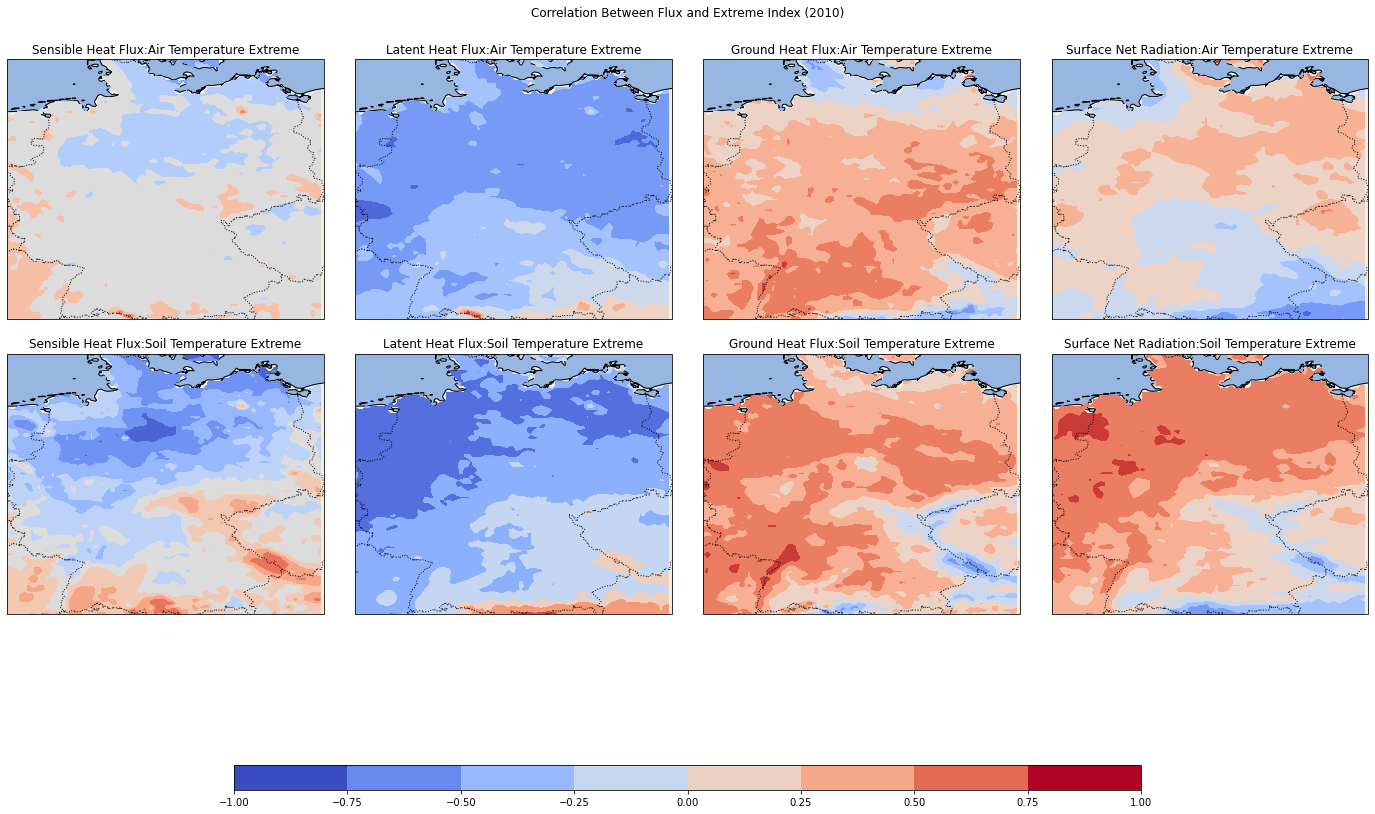

In [14]:
fig,ax = plt.subplots(3,4,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(21,17))
fig.suptitle('Correlation Between Flux and Extreme Index (2010)', y = 0.84)

ax[0][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][0].add_feature(cfeature.LAND)
ax[0][0].add_feature(cfeature.OCEAN)
ax[0][0].add_feature(cfeature.COASTLINE)

ax[0][0].set_title('Sensible Heat Flux:Air Temperature Extreme')
c00 = ax[0][0].contourf(H_longitude,H_latitude, H_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][0].add_feature(cfeature.LAND)
ax[1][0].add_feature(cfeature.OCEAN)
ax[1][0].add_feature(cfeature.COASTLINE)

ax[1][0].set_title('Sensible Heat Flux:Soil Temperature Extreme')
c10 = ax[1][0].contourf(H_longitude,H_latitude, H_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][1].add_feature(cfeature.LAND)
ax[0][1].add_feature(cfeature.OCEAN)
ax[0][1].add_feature(cfeature.COASTLINE)

ax[0][1].set_title('Latent Heat Flux:Air Temperature Extreme')
c01 = ax[0][1].contourf(LHF_longitude,LHF_latitude, LHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][1].add_feature(cfeature.LAND)
ax[1][1].add_feature(cfeature.OCEAN)
ax[1][1].add_feature(cfeature.COASTLINE)

ax[1][1].set_title('Latent Heat Flux:Soil Temperature Extreme')
c11 = ax[1][1].contourf(LHF_longitude,LHF_latitude, LHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][2].add_feature(cfeature.LAND)
ax[0][2].add_feature(cfeature.OCEAN)
ax[0][2].add_feature(cfeature.COASTLINE)

ax[0][2].set_title('Ground Heat Flux:Air Temperature Extreme')
c02 = ax[0][2].contourf(GHF_longitude,GHF_latitude, GHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][2].add_feature(cfeature.LAND)
ax[1][2].add_feature(cfeature.OCEAN)
ax[1][2].add_feature(cfeature.COASTLINE)

ax[1][2].set_title('Ground Heat Flux:Soil Temperature Extreme')
c12 = ax[1][2].contourf(GHF_longitude,GHF_latitude, GHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][3].add_feature(cfeature.LAND)
ax[0][3].add_feature(cfeature.OCEAN)
ax[0][3].add_feature(cfeature.COASTLINE)

ax[0][3].set_title('Surface Net Radiation:Air Temperature Extreme')
c03 = ax[0][3].contourf(SNR_longitude,SNR_latitude, SNR_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][3].add_feature(cfeature.LAND)
ax[1][3].add_feature(cfeature.OCEAN)
ax[1][3].add_feature(cfeature.COASTLINE)

ax[1][3].set_title('Surface Net Radiation:Soil Temperature Extreme')
c03 = ax[1][3].contourf(SNR_longitude,SNR_latitude, SNR_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
for i in range(0,4):
    fig.delaxes(ax[2][i])
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

fig.subplots_adjust(bottom=0.1, top=0.8, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.1)

cmap = mpl.cm.coolwarm
bounds = np.arange(-1,1.25,0.25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal')


#plt.tight_layout()
plt.show()
#fig.savefig('2010 Correlation Map.png', format = 'png')

In [15]:
ext_GHF_tas = np.ndarray(shape=(75,90))
gridcorr(GHF_daily_avg,tas['t2m'].values[1:,:,:],ext_GHF_tas)
ext_GHF_tsl = np.ndarray(shape=(75,90))
gridcorr(GHF_daily_avg,tsl['stl1'].values[1:,:,:],ext_GHF_tsl)

ext_LHF_tas = np.ndarray(shape=(75,90))
gridcorr(LHF_daily_avg,tas['t2m'].values[1:,:,:],ext_LHF_tas)
ext_LHF_tsl = np.ndarray(shape=(75,90))
gridcorr(LHF_daily_avg,tsl['stl1'].values[1:,:,:],ext_LHF_tsl)

ext_H_tas = np.ndarray(shape=(75,90))
gridcorr(H_daily_avg,tas['t2m'].values[1:,:,:],ext_H_tas)
ext_H_tsl = np.ndarray(shape=(75,90))
gridcorr(H_daily_avg,tsl['stl1'].values[1:,:,:],ext_H_tsl)

ext_SNR_tas = np.ndarray(shape=(75,90))
gridcorr(SNR_daily_avg,tas['t2m'].values[1:,:,:],ext_SNR_tas)
ext_SNR_tsl = np.ndarray(shape=(75,90))
gridcorr(SNR_daily_avg,tsl['stl1'].values[1:,:,:],ext_SNR_tsl)


array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.30023135, 0.31183237, 0.25411969, ..., 0.08001887, 0.04985296,
        0.05028254],
       [0.19408004, 0.22705058, 0.26381114, ..., 0.07556802, 0.0059259 ,
        0.03692981],
       [0.21699107, 0.18437948, 0.20544828, ..., 0.04038739, 0.04647553,
        0.02076095]])

C:\Users\andersg\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


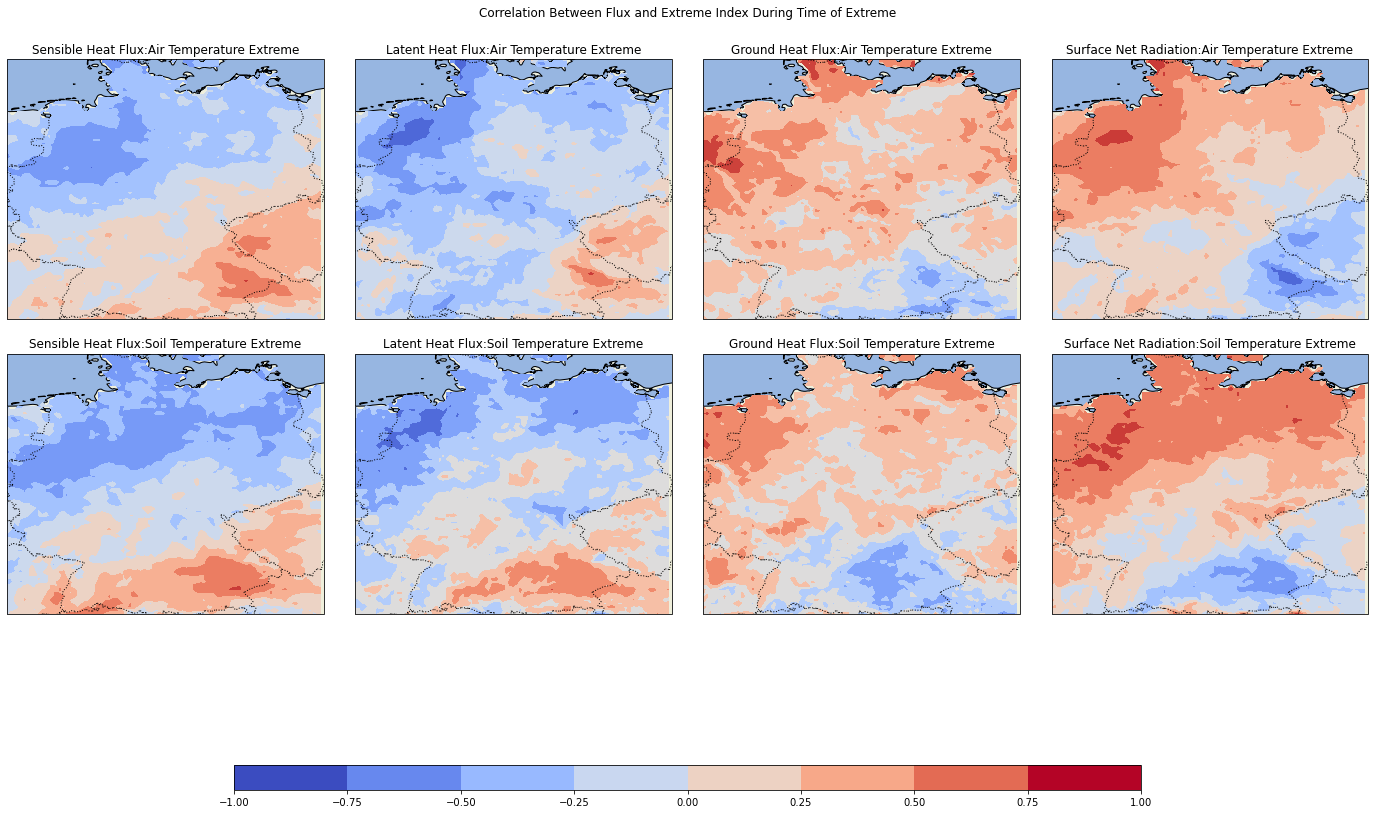

In [16]:
fig,ax = plt.subplots(3,4,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(21,17))
fig.suptitle('Correlation Between Flux and Extreme Index During Time of Extreme', y = 0.84)

ax[0][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][0].add_feature(cfeature.LAND)
ax[0][0].add_feature(cfeature.OCEAN)
ax[0][0].add_feature(cfeature.COASTLINE)

ax[0][0].set_title('Sensible Heat Flux:Air Temperature Extreme')
c00 = ax[0][0].contourf(H_longitude,H_latitude, ext_H_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][0].add_feature(cfeature.LAND)
ax[1][0].add_feature(cfeature.OCEAN)
ax[1][0].add_feature(cfeature.COASTLINE)

ax[1][0].set_title('Sensible Heat Flux:Soil Temperature Extreme')
c10 = ax[1][0].contourf(H_longitude,H_latitude, ext_H_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][1].add_feature(cfeature.LAND)
ax[0][1].add_feature(cfeature.OCEAN)
ax[0][1].add_feature(cfeature.COASTLINE)

ax[0][1].set_title('Latent Heat Flux:Air Temperature Extreme')
c01 = ax[0][1].contourf(LHF_longitude,LHF_latitude, ext_LHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][1].add_feature(cfeature.LAND)
ax[1][1].add_feature(cfeature.OCEAN)
ax[1][1].add_feature(cfeature.COASTLINE)

ax[1][1].set_title('Latent Heat Flux:Soil Temperature Extreme')
c11 = ax[1][1].contourf(LHF_longitude,LHF_latitude, ext_LHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][2].add_feature(cfeature.LAND)
ax[0][2].add_feature(cfeature.OCEAN)
ax[0][2].add_feature(cfeature.COASTLINE)

ax[0][2].set_title('Ground Heat Flux:Air Temperature Extreme')
c02 = ax[0][2].contourf(GHF_longitude,GHF_latitude, ext_GHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][2].add_feature(cfeature.LAND)
ax[1][2].add_feature(cfeature.OCEAN)
ax[1][2].add_feature(cfeature.COASTLINE)

ax[1][2].set_title('Ground Heat Flux:Soil Temperature Extreme')
c12 = ax[1][2].contourf(GHF_longitude,GHF_latitude, ext_GHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][3].add_feature(cfeature.LAND)
ax[0][3].add_feature(cfeature.OCEAN)
ax[0][3].add_feature(cfeature.COASTLINE)

ax[0][3].set_title('Surface Net Radiation:Air Temperature Extreme')
c03 = ax[0][3].contourf(SNR_longitude,SNR_latitude, ext_SNR_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][3].add_feature(cfeature.LAND)
ax[1][3].add_feature(cfeature.OCEAN)
ax[1][3].add_feature(cfeature.COASTLINE)

ax[1][3].set_title('Surface Net Radiation:Soil Temperature Extreme')
c03 = ax[1][3].contourf(SNR_longitude,SNR_latitude, ext_SNR_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
for i in range(0,4):
    fig.delaxes(ax[2][i])
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

fig.subplots_adjust(bottom=0.1, top=0.8, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.1)

cmap = mpl.cm.coolwarm
bounds = np.arange(-1,1.25,0.25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal')

#plt.tight_layout()
plt.show()
#fig.savefig('Correlation Map During Extremes.png', format = 'png')

In [17]:
ind_tas = np.ndarray(shape=(364,75,90))
ind_tsl = np.ndarray(shape=(364,75,90))
premask(tas['t2m'].values[1:,:,:],ind_tas)
premask(tsl['stl1'].values[1:,:,:],ind_tsl)

tas_index = ind_tas * tas['t2m'].values[1:,:,:]
tsl_index = ind_tsl * tsl['stl1'].values[1:,:,:]

pre_GHF_tas = ind_tas * GHF_daily_avg[:,:,:]
pre_GHF_tsl = ind_tsl * GHF_daily_avg[:,:,:]
pre_LHF_tas = ind_tas * LHF_daily_avg[:,:,:]
pre_LHF_tsl = ind_tsl * LHF_daily_avg[:,:,:]
pre_H_tas = ind_tas * H_daily_avg[:,:,:]
pre_H_tsl = ind_tsl * H_daily_avg[:,:,:]
pre_SNR_tas = ind_tas * SNR_daily_avg[:,:,:]
pre_SNR_tsl = ind_tsl * SNR_daily_avg[:,:,:]

ext0_GHF_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index,pre_GHF_tas,ext0_GHF_tas)
ext0_GHF_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index,pre_GHF_tsl,ext0_GHF_tsl)

ext0_LHF_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index,pre_LHF_tas,ext0_LHF_tas)
ext0_LHF_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index,pre_LHF_tsl,ext0_LHF_tsl)

ext0_H_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index,pre_H_tas,ext0_H_tas)
ext0_H_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index,pre_H_tsl,ext0_H_tsl)

ext0_SNR_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index,pre_SNR_tas,ext0_SNR_tas)
ext0_SNR_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index,pre_SNR_tsl,ext0_SNR_tsl)

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.37436298, 0.37129924, 0.37353142, ..., 0.06097475, 0.057186  ,
        0.07718392],
       [0.35252728, 0.35789095, 0.38448698, ..., 0.08727594, 0.09384207,
        0.09689699],
       [0.37234121, 0.35665835, 0.39806179, ..., 0.10462927, 0.09674479,
        0.05958671]])

C:\Users\andersg\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


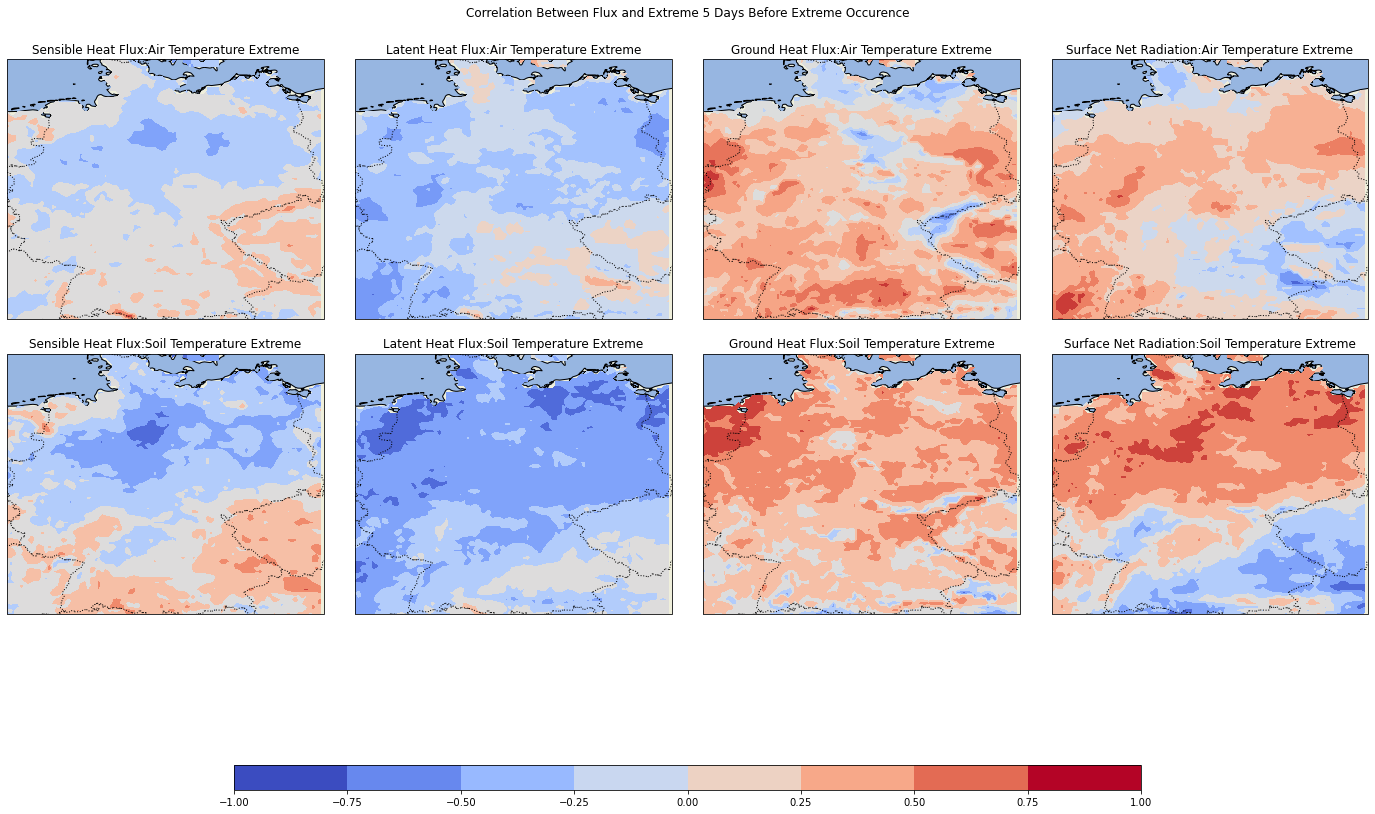

In [18]:
fig,ax = plt.subplots(3,4,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(21,17))
fig.suptitle('Correlation Between Flux and Extreme 5 Days Before Extreme Occurence', y = 0.84)

ax[0][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][0].add_feature(cfeature.LAND)
ax[0][0].add_feature(cfeature.OCEAN)
ax[0][0].add_feature(cfeature.COASTLINE)

ax[0][0].set_title('Sensible Heat Flux:Air Temperature Extreme')
c00 = ax[0][0].contourf(H_longitude,H_latitude, ext0_H_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][0].add_feature(cfeature.LAND)
ax[1][0].add_feature(cfeature.OCEAN)
ax[1][0].add_feature(cfeature.COASTLINE)

ax[1][0].set_title('Sensible Heat Flux:Soil Temperature Extreme')
c10 = ax[1][0].contourf(H_longitude,H_latitude, ext0_H_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][1].add_feature(cfeature.LAND)
ax[0][1].add_feature(cfeature.OCEAN)
ax[0][1].add_feature(cfeature.COASTLINE)

ax[0][1].set_title('Latent Heat Flux:Air Temperature Extreme')
c01 = ax[0][1].contourf(LHF_longitude,LHF_latitude, ext0_LHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][1].add_feature(cfeature.LAND)
ax[1][1].add_feature(cfeature.OCEAN)
ax[1][1].add_feature(cfeature.COASTLINE)

ax[1][1].set_title('Latent Heat Flux:Soil Temperature Extreme')
c11 = ax[1][1].contourf(LHF_longitude,LHF_latitude, ext0_LHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][2].add_feature(cfeature.LAND)
ax[0][2].add_feature(cfeature.OCEAN)
ax[0][2].add_feature(cfeature.COASTLINE)

ax[0][2].set_title('Ground Heat Flux:Air Temperature Extreme')
c02 = ax[0][2].contourf(GHF_longitude,GHF_latitude, ext0_GHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][2].add_feature(cfeature.LAND)
ax[1][2].add_feature(cfeature.OCEAN)
ax[1][2].add_feature(cfeature.COASTLINE)

ax[1][2].set_title('Ground Heat Flux:Soil Temperature Extreme')
c12 = ax[1][2].contourf(GHF_longitude,GHF_latitude, ext0_GHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][3].add_feature(cfeature.LAND)
ax[0][3].add_feature(cfeature.OCEAN)
ax[0][3].add_feature(cfeature.COASTLINE)

ax[0][3].set_title('Surface Net Radiation:Air Temperature Extreme')
c03 = ax[0][3].contourf(SNR_longitude,SNR_latitude, ext0_SNR_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][3].add_feature(cfeature.LAND)
ax[1][3].add_feature(cfeature.OCEAN)
ax[1][3].add_feature(cfeature.COASTLINE)

ax[1][3].set_title('Surface Net Radiation:Soil Temperature Extreme')
c03 = ax[1][3].contourf(SNR_longitude,SNR_latitude, ext0_SNR_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
for i in range(0,4):
    fig.delaxes(ax[2][i])
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

fig.subplots_adjust(bottom=0.1, top=0.8, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.1)

cmap = mpl.cm.coolwarm
bounds = np.arange(-1,1.25,0.25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal')

#plt.tight_layout()
plt.show()
#fig.savefig('Correlation Map Before Extremes.png', format = 'png')

In [19]:
ind_tas1 = np.ndarray(shape=(364,75,90))
ind_tsl1 = np.ndarray(shape=(364,75,90))
postmask(tas['t2m'].values[1:,:,:],ind_tas1)
postmask(tsl['stl1'].values[1:,:,:],ind_tsl1)

tas_index1 = ind_tas1 * tas['t2m'].values[1:,:,:]
tsl_index1 = ind_tsl1 * tsl['stl1'].values[1:,:,:]

post_GHF_tas = ind_tas1 * GHF_daily_avg[:,:,:]
post_GHF_tsl = ind_tsl1 * GHF_daily_avg[:,:,:]
post_LHF_tas = ind_tas1 * LHF_daily_avg[:,:,:]
post_LHF_tsl = ind_tsl1 * LHF_daily_avg[:,:,:]
post_H_tas = ind_tas1 * H_daily_avg[:,:,:]
post_H_tsl = ind_tsl1 * H_daily_avg[:,:,:]
post_SNR_tas = ind_tas1 * SNR_daily_avg[:,:,:]
post_SNR_tsl = ind_tsl1 * SNR_daily_avg[:,:,:]

ext1_GHF_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index1,post_GHF_tas,ext1_GHF_tas)
ext1_GHF_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index1,post_GHF_tsl,ext1_GHF_tsl)

ext1_LHF_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index1,post_LHF_tas,ext1_LHF_tas)
ext1_LHF_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index1,post_LHF_tsl,ext1_LHF_tsl)

ext1_H_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index1,post_H_tas,ext1_H_tas)
ext1_H_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index1,post_H_tsl,ext1_H_tsl)

ext1_SNR_tas = np.ndarray(shape=(75,90))
mapcorr2(tas_index1,post_SNR_tas,ext1_SNR_tas)
ext1_SNR_tsl = np.ndarray(shape=(75,90))
mapcorr2(tsl_index1,post_SNR_tsl,ext1_SNR_tsl)

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.27192443, 0.26661664, 0.28792244, ..., 0.164719  , 0.16331087,
        0.15671123],
       [0.28825316, 0.28075616, 0.30413768, ..., 0.17156661, 0.1418566 ,
        0.14641241],
       [0.278008  , 0.30487534, 0.31188452, ..., 0.14491157, 0.14142701,
        0.11625838]])

C:\Users\andersg\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


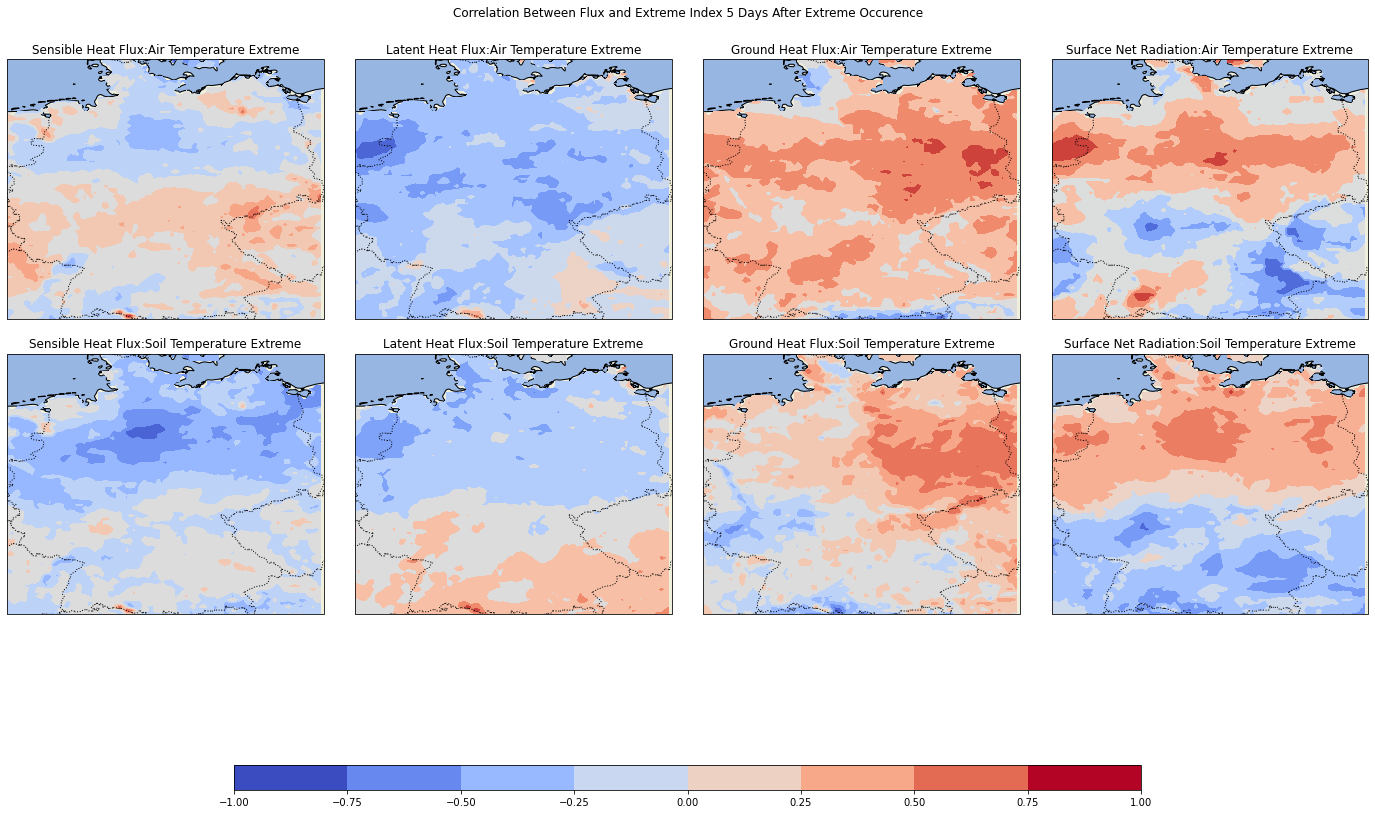

In [20]:
fig,ax = plt.subplots(3,4,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(21,17))
fig.suptitle('Correlation Between Flux and Extreme Index 5 Days After Extreme Occurence', y = 0.84)

ax[0][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][0].add_feature(cfeature.LAND)
ax[0][0].add_feature(cfeature.OCEAN)
ax[0][0].add_feature(cfeature.COASTLINE)

ax[0][0].set_title('Sensible Heat Flux:Air Temperature Extreme')
c00 = ax[0][0].contourf(H_longitude,H_latitude, ext1_H_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][0].add_feature(cfeature.LAND)
ax[1][0].add_feature(cfeature.OCEAN)
ax[1][0].add_feature(cfeature.COASTLINE)

ax[1][0].set_title('Sensible Heat Flux:Soil Temperature Extreme')
c10 = ax[1][0].contourf(H_longitude,H_latitude, ext1_H_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][0].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][1].add_feature(cfeature.LAND)
ax[0][1].add_feature(cfeature.OCEAN)
ax[0][1].add_feature(cfeature.COASTLINE)

ax[0][1].set_title('Latent Heat Flux:Air Temperature Extreme')
c01 = ax[0][1].contourf(LHF_longitude,LHF_latitude, ext1_LHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][1].add_feature(cfeature.LAND)
ax[1][1].add_feature(cfeature.OCEAN)
ax[1][1].add_feature(cfeature.COASTLINE)

ax[1][1].set_title('Latent Heat Flux:Soil Temperature Extreme')
c11 = ax[1][1].contourf(LHF_longitude,LHF_latitude, ext1_LHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][1].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][2].add_feature(cfeature.LAND)
ax[0][2].add_feature(cfeature.OCEAN)
ax[0][2].add_feature(cfeature.COASTLINE)

ax[0][2].set_title('Ground Heat Flux:Air Temperature Extreme')
c02 = ax[0][2].contourf(GHF_longitude,GHF_latitude, ext1_GHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][2].add_feature(cfeature.LAND)
ax[1][2].add_feature(cfeature.OCEAN)
ax[1][2].add_feature(cfeature.COASTLINE)

ax[1][2].set_title('Ground Heat Flux:Soil Temperature Extreme')
c12 = ax[1][2].contourf(GHF_longitude,GHF_latitude, ext1_GHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][2].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[0][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][3].add_feature(cfeature.LAND)
ax[0][3].add_feature(cfeature.OCEAN)
ax[0][3].add_feature(cfeature.COASTLINE)

ax[0][3].set_title('Surface Net Radiation:Air Temperature Extreme')
c03 = ax[0][3].contourf(SNR_longitude,SNR_latitude, ext1_SNR_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
ax[1][3].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][3].add_feature(cfeature.LAND)
ax[1][3].add_feature(cfeature.OCEAN)
ax[1][3].add_feature(cfeature.COASTLINE)

ax[1][3].set_title('Surface Net Radiation:Soil Temperature Extreme')
c03 = ax[1][3].contourf(SNR_longitude,SNR_latitude, ext1_SNR_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][3].add_feature(cfeature.BORDERS, linestyle=':')
#-----------------------------------------------------------------------------------------------------------------
for i in range(0,4):
    fig.delaxes(ax[2][i])
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

fig.subplots_adjust(bottom=0.1, top=0.8, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.1)

cmap = mpl.cm.coolwarm
bounds = np.arange(-1,1.25,0.25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal')

#plt.tight_layout()
plt.show()
#fig.savefig('Correlation Map After Extremes.png', format = 'png')

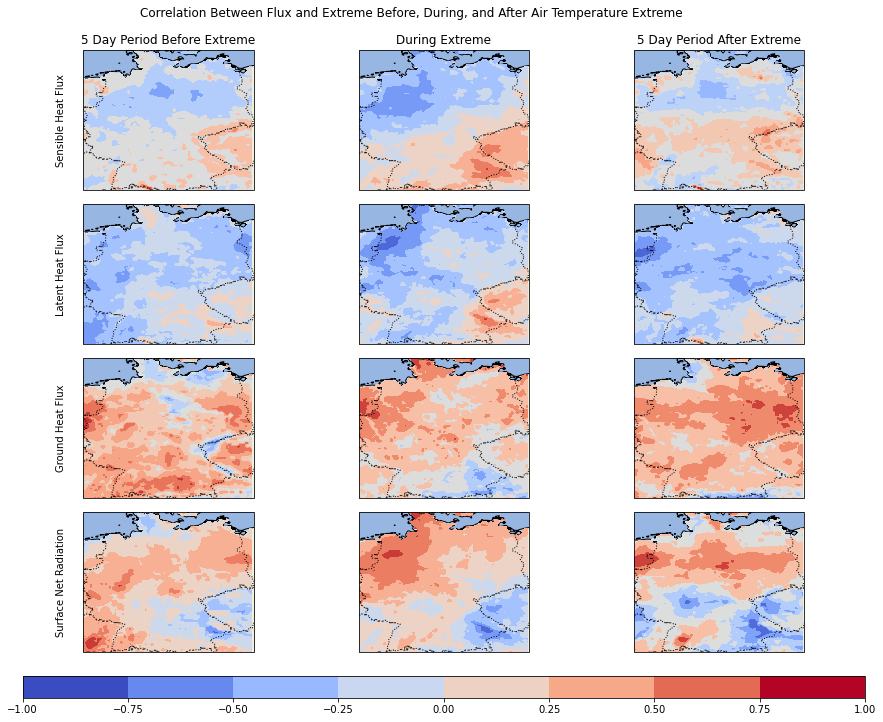

In [98]:
fig,ax = plt.subplots(5,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(18,15))
fig.suptitle('Correlation Between Flux and Extreme Before, During, and After Air Temperature Extreme', y = 0.84)

for i in range(0,3):
    fig.delaxes(ax[4][i])
cbar_ax = fig.add_axes([0.2, 0.2, 0.65, 0.02])



cmap = mpl.cm.coolwarm
bounds = np.arange(-1,1.25,0.25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal')
#----------------------------------------------------------------------------------------------------------------------------
ax[0][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][0].add_feature(cfeature.LAND)
ax[0][0].add_feature(cfeature.OCEAN)
ax[0][0].add_feature(cfeature.COASTLINE)
ax[0][0].text(-0.1,0.5,'Sensible Heat Flux', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[0][0].transAxes)
ax[0][0].set_title('5 Day Period Before Extreme')
c00 = ax[0][0].contourf(H_longitude,H_latitude, ext0_H_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[0][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][1].add_feature(cfeature.LAND)
ax[0][1].add_feature(cfeature.OCEAN)
ax[0][1].add_feature(cfeature.COASTLINE)
ax[0][1].set_ylabel('Sensible Heat Flux')
ax[0][1].set_title('During Extreme')
c01 = ax[0][1].contourf(H_longitude,H_latitude, ext_H_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[0][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][2].add_feature(cfeature.LAND)
ax[0][2].add_feature(cfeature.OCEAN)
ax[0][2].add_feature(cfeature.COASTLINE)
ax[0][2].set_ylabel('Sensible Heat Flux')
ax[0][2].set_title('5 Day Period After Extreme')
c02 = ax[0][2].contourf(H_longitude,H_latitude, ext1_H_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[1][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][0].add_feature(cfeature.LAND)
ax[1][0].add_feature(cfeature.OCEAN)
ax[1][0].add_feature(cfeature.COASTLINE)
ax[1][0].text(-0.1,0.5,'Latent Heat Flux', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[1][0].transAxes)
c10 = ax[1][0].contourf(LHF_longitude,LHF_latitude, ext0_LHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[1][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][1].add_feature(cfeature.LAND)
ax[1][1].add_feature(cfeature.OCEAN)
ax[1][1].add_feature(cfeature.COASTLINE)
ax[1][1].set_ylabel('Latent Heat Flux')
c11 = ax[1][1].contourf(LHF_longitude,LHF_latitude, ext_LHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[1][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][2].add_feature(cfeature.LAND)
ax[1][2].add_feature(cfeature.OCEAN)
ax[1][2].add_feature(cfeature.COASTLINE)
ax[1][2].set_ylabel('Latent Heat Flux')
c12 = ax[1][2].contourf(LHF_longitude,LHF_latitude, ext1_LHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[2][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[2][0].add_feature(cfeature.LAND)
ax[2][0].add_feature(cfeature.OCEAN)
ax[2][0].add_feature(cfeature.COASTLINE)
ax[2][0].text(-0.1,0.5,'Ground Heat Flux', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[2][0].transAxes)
c20 = ax[2][0].contourf(GHF_longitude,GHF_latitude, ext0_GHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[2][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[2][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[2][1].add_feature(cfeature.LAND)
ax[2][1].add_feature(cfeature.OCEAN)
ax[2][1].add_feature(cfeature.COASTLINE)
ax[2][1].set_ylabel('Ground Heat Flux')
c21 = ax[2][1].contourf(GHF_longitude,GHF_latitude, ext_GHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[2][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[2][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[2][2].add_feature(cfeature.LAND)
ax[2][2].add_feature(cfeature.OCEAN)
ax[2][2].add_feature(cfeature.COASTLINE)
ax[2][2].set_ylabel('Ground Heat Flux')
c22 = ax[2][2].contourf(GHF_longitude,GHF_latitude, ext1_GHF_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[2][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[3][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[3][0].add_feature(cfeature.LAND)
ax[3][0].add_feature(cfeature.OCEAN)
ax[3][0].add_feature(cfeature.COASTLINE)
ax[3][0].text(-0.1,0.5,'Surface Net Radiation', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[3][0].transAxes)
c30 = ax[3][0].contourf(SNR_longitude,SNR_latitude, ext0_SNR_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[3][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[3][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[3][1].add_feature(cfeature.LAND)
ax[3][1].add_feature(cfeature.OCEAN)
ax[3][1].add_feature(cfeature.COASTLINE)
ax[3][1].set_ylabel('Surface Net Radiation')
c31 = ax[3][1].contourf(SNR_longitude,SNR_latitude, ext_SNR_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[3][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[3][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[3][2].add_feature(cfeature.LAND)
ax[3][2].add_feature(cfeature.OCEAN)
ax[3][2].add_feature(cfeature.COASTLINE)
ax[3][2].set_ylabel('Surface Net Radiation')
c32 = ax[3][2].contourf(SNR_longitude,SNR_latitude, ext1_SNR_tas,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[3][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------


fig.subplots_adjust(bottom=0.1, top=0.8, left=0.1, right=0.95,
                    wspace=-0.5, hspace=0.1)
#plt.tight_layout()
plt.show()
fig.savefig('Correlation Map All Air Extremes.png', format = 'png')

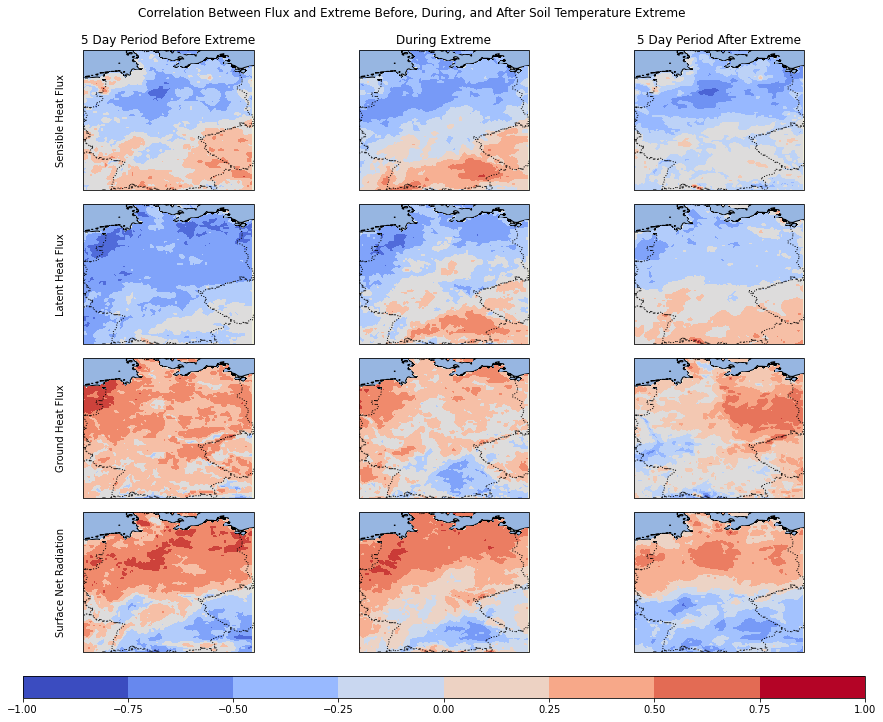

In [99]:
fig,ax = plt.subplots(5,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(18,15))
fig.suptitle('Correlation Between Flux and Extreme Before, During, and After Soil Temperature Extreme', y = 0.84)

for i in range(0,3):
    fig.delaxes(ax[4][i])
cbar_ax = fig.add_axes([0.2, 0.2, 0.65, 0.02])



cmap = mpl.cm.coolwarm
bounds = np.arange(-1,1.25,0.25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal')
#----------------------------------------------------------------------------------------------------------------------------
ax[0][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][0].add_feature(cfeature.LAND)
ax[0][0].add_feature(cfeature.OCEAN)
ax[0][0].add_feature(cfeature.COASTLINE)
ax[0][0].text(-0.1,0.5,'Sensible Heat Flux', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[0][0].transAxes)
ax[0][0].set_title('5 Day Period Before Extreme')
c00 = ax[0][0].contourf(H_longitude,H_latitude, ext0_H_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[0][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][1].add_feature(cfeature.LAND)
ax[0][1].add_feature(cfeature.OCEAN)
ax[0][1].add_feature(cfeature.COASTLINE)
ax[0][1].set_ylabel('Sensible Heat Flux')
ax[0][1].set_title('During Extreme')
c01 = ax[0][1].contourf(H_longitude,H_latitude, ext_H_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[0][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[0][2].add_feature(cfeature.LAND)
ax[0][2].add_feature(cfeature.OCEAN)
ax[0][2].add_feature(cfeature.COASTLINE)
ax[0][2].set_ylabel('Sensible Heat Flux')
ax[0][2].set_title('5 Day Period After Extreme')
c02 = ax[0][2].contourf(H_longitude,H_latitude, ext1_H_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[0][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[1][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][0].add_feature(cfeature.LAND)
ax[1][0].add_feature(cfeature.OCEAN)
ax[1][0].add_feature(cfeature.COASTLINE)
ax[1][0].text(-0.1,0.5,'Latent Heat Flux', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[1][0].transAxes)
c10 = ax[1][0].contourf(LHF_longitude,LHF_latitude, ext0_LHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[1][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][1].add_feature(cfeature.LAND)
ax[1][1].add_feature(cfeature.OCEAN)
ax[1][1].add_feature(cfeature.COASTLINE)
ax[1][1].set_ylabel('Latent Heat Flux')
c11 = ax[1][1].contourf(LHF_longitude,LHF_latitude, ext_LHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[1][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[1][2].add_feature(cfeature.LAND)
ax[1][2].add_feature(cfeature.OCEAN)
ax[1][2].add_feature(cfeature.COASTLINE)
ax[1][2].set_ylabel('Latent Heat Flux')
c12 = ax[1][2].contourf(LHF_longitude,LHF_latitude, ext1_LHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[1][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[2][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[2][0].add_feature(cfeature.LAND)
ax[2][0].add_feature(cfeature.OCEAN)
ax[2][0].add_feature(cfeature.COASTLINE)
ax[2][0].text(-0.1,0.5,'Ground Heat Flux', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[2][0].transAxes)
c20 = ax[2][0].contourf(GHF_longitude,GHF_latitude, ext0_GHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[2][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[2][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[2][1].add_feature(cfeature.LAND)
ax[2][1].add_feature(cfeature.OCEAN)
ax[2][1].add_feature(cfeature.COASTLINE)
ax[2][1].set_ylabel('Ground Heat Flux')
c21 = ax[2][1].contourf(GHF_longitude,GHF_latitude, ext_GHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[2][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[2][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[2][2].add_feature(cfeature.LAND)
ax[2][2].add_feature(cfeature.OCEAN)
ax[2][2].add_feature(cfeature.COASTLINE)
ax[2][2].set_ylabel('Ground Heat Flux')
c22 = ax[2][2].contourf(GHF_longitude,GHF_latitude, ext1_GHF_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[2][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[3][0].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[3][0].add_feature(cfeature.LAND)
ax[3][0].add_feature(cfeature.OCEAN)
ax[3][0].add_feature(cfeature.COASTLINE)
ax[3][0].text(-0.1,0.5,'Surface Net Radiation', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', transform = ax[3][0].transAxes)
c30 = ax[3][0].contourf(SNR_longitude,SNR_latitude, ext0_SNR_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[3][0].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[3][1].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[3][1].add_feature(cfeature.LAND)
ax[3][1].add_feature(cfeature.OCEAN)
ax[3][1].add_feature(cfeature.COASTLINE)
ax[3][1].set_ylabel('Surface Net Radiation')
c31 = ax[3][1].contourf(SNR_longitude,SNR_latitude, ext_SNR_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[3][1].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------
ax[3][2].set_extent([6, 15, 47.5, 54.9], crs=ccrs.PlateCarree())
ax[3][2].add_feature(cfeature.LAND)
ax[3][2].add_feature(cfeature.OCEAN)
ax[3][2].add_feature(cfeature.COASTLINE)
ax[3][2].set_ylabel('Surface Net Radiation')
c32 = ax[3][2].contourf(SNR_longitude,SNR_latitude, ext1_SNR_tsl,transform=ccrs.PlateCarree(), cmap = 'coolwarm',label = 'Correlation')
ax[3][2].add_feature(cfeature.BORDERS, linestyle=':')
#----------------------------------------------------------------------------------------------------------------------------


fig.subplots_adjust(bottom=0.1, top=0.8, left=0.1, right=0.95,
                    wspace=-0.5, hspace=0.1)
#plt.tight_layout()
plt.show()
fig.savefig('Correlation Map All Soil Extremes.png', format = 'png')